## 1. Importação de Bibliotecas

Importamos todas as bibliotecas necessárias para o treinamento e avaliação dos modelos:

In [11]:
# Importações necessárias
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
import joblib

## 2. Carregamento dos Dados Processados

Carregamos os datasets que foram processados no notebook anterior:

In [12]:
print("--- Carregando os datasets preparados ---")
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('validation_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Combinar treino e validação para o GridSearchCV
full_train_df = pd.concat([train_df, val_df])

# Separar features e target
X_train = full_train_df.drop('target', axis=1)
y_train = full_train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Carregar encoders
label_encoder = joblib.load('label_encoder.joblib')

# Obter nomes das classes para relatórios
target_names = label_encoder.classes_

print(f"Dataset de treino: {X_train.shape[0]} amostras")
print(f"Dataset de teste: {X_test.shape[0]} amostras")
print(f"Classes: {target_names}")

--- Carregando os datasets preparados ---
Dataset de treino: 600 amostras
Dataset de teste: 150 amostras
Classes: ['Fim de Jogo' 'Possibilidade de Fim' 'Tem Jogo']


## 3. Otimização de Hiperparâmetros

### 3.1 k-Nearest Neighbors (k-NN)

In [13]:
print("\n--- Otimizando k-NN ---")
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_models = {'k-NN': grid_knn.best_estimator_}
print(f"Melhores parâmetros: {grid_knn.best_params_}")


--- Otimizando k-NN ---
Melhores parâmetros: {'n_neighbors': 5, 'weights': 'distance'}
Melhores parâmetros: {'n_neighbors': 5, 'weights': 'distance'}


### 3.2 Árvore de Decisão

In [14]:
print("\n--- Otimizando Decision Tree ---")
param_grid_dt = {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_models['Decision Tree'] = grid_dt.best_estimator_
print(f"Melhores parâmetros: {grid_dt.best_params_}")


--- Otimizando Decision Tree ---
Melhores parâmetros: {'max_depth': 10, 'min_samples_split': 2}


### 3.3 Multi-layer Perceptron (MLP)

In [15]:
print("\n--- Otimizando MLP ---")
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.001, 0.01]}
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_models['MLP'] = grid_mlp.best_estimator_
print(f"Melhores parâmetros: {grid_mlp.best_params_}")


--- Otimizando MLP ---
Melhores parâmetros: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}
Melhores parâmetros: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}


### 3.4 Random Forest

In [16]:
print("\n--- Otimizando Random Forest ---")
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_models['Random Forest'] = grid_rf.best_estimator_
print(f"Melhores parâmetros: {grid_rf.best_params_}")


--- Otimizando Random Forest ---
Melhores parâmetros: {'max_depth': None, 'n_estimators': 100}
Melhores parâmetros: {'max_depth': None, 'n_estimators': 100}


## 4. Avaliação dos Modelos no Conjunto de Teste

Avaliamos todos os modelos otimizados no conjunto de teste:

In [17]:
print("--- Avaliação dos Modelos no Conjunto de Teste ---")
results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    results[name] = f1_weighted
    
    print(f"\n--- Relatório para: {name} ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

--- Avaliação dos Modelos no Conjunto de Teste ---

--- Relatório para: k-NN ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.83      1.00      0.91        50
Possibilidade de Fim       0.76      0.38      0.51        50
            Tem Jogo       0.65      0.84      0.73        50

            accuracy                           0.74       150
           macro avg       0.75      0.74      0.72       150
        weighted avg       0.75      0.74      0.72       150


--- Relatório para: Decision Tree ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.69      0.68      0.69        50
Possibilidade de Fim       0.64      0.60      0.62        50
            Tem Jogo       0.76      0.82      0.79        50

            accuracy                           0.70       150
           macro avg       0.70      0.70      0.70       150
        weighted avg       0.70      0.70      0.70       150


--- R

## 5. Comparação e Visualização dos Resultados

Criamos uma tabela comparativa e visualizamos o desempenho dos modelos:

=== COMPARAÇÃO FINAL DOS MODELOS ===
       Algoritmo  F1-Score
2            MLP  0.885637
3  Random Forest  0.805974
0           k-NN  0.715397
1  Decision Tree  0.697962


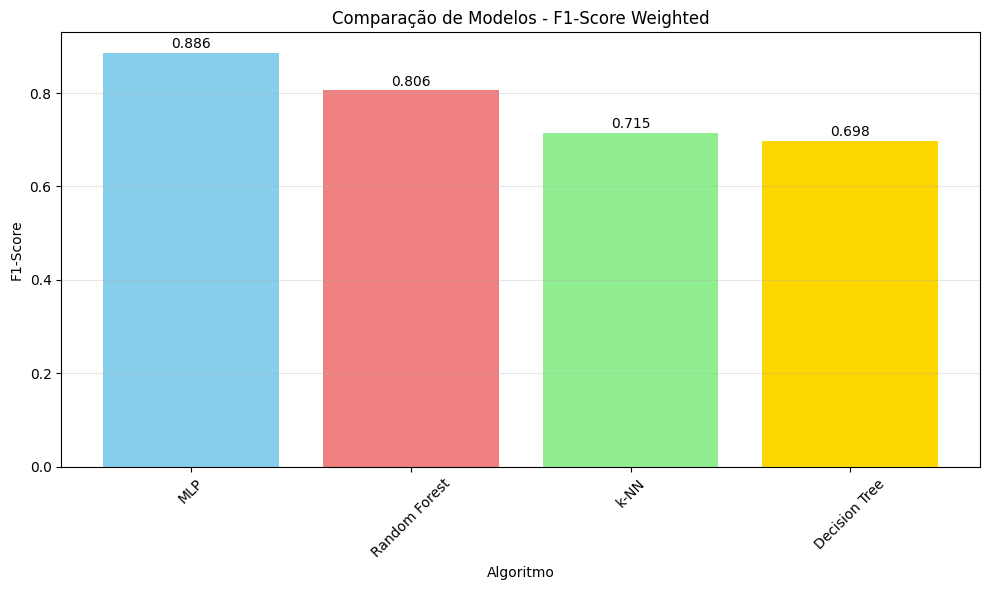

In [18]:
import matplotlib.pyplot as plt

# Criar DataFrame com os resultados
results_df = pd.DataFrame(list(results.items()), columns=['Algoritmo', 'F1-Score'])
results_df = results_df.sort_values('F1-Score', ascending=False)

print("=== COMPARAÇÃO FINAL DOS MODELOS ===")
print(results_df)

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algoritmo'], results_df['F1-Score'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Comparação de Modelos - F1-Score Weighted')
plt.xlabel('Algoritmo')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Adicionar valores no topo das barras
for i, v in enumerate(results_df['F1-Score']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('comparacao_modelos.png')
plt.show()

## 6. Seleção e Salvamento do Melhor Modelo

Selecionamos o modelo com melhor desempenho e o salvamos para uso futuro:

In [19]:
print("--- Salvando o Melhor Modelo ---")

# Selecionar o melhor modelo baseado no F1-Score
best_model_name = results_df.iloc[0]['Algoritmo']
best_model_object = best_models[best_model_name]

print(f"Melhor modelo: {best_model_name}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Salvar o melhor modelo
joblib.dump(best_model_object, 'best_classifier.joblib')
print(f"Modelo '{best_model_name}' salvo como 'best_classifier.joblib'")

print("\n=== RESUMO FINAL ===")
print(f"✅ Melhor Algoritmo: {best_model_name}")
print(f"📊 F1-Score Alcançado: {results_df.iloc[0]['F1-Score']:.4f}")
print("🎯 O modelo está pronto para uso na aplicação!")

# Exibir informações detalhadas do melhor modelo
if hasattr(best_model_object, 'get_params'):
    print(f"\nParâmetros do modelo '{best_model_name}':")
    for param, value in best_model_object.get_params().items():
        print(f"  {param}: {value}")

print("\nArquivos gerados:")
print("- best_classifier.joblib (modelo treinado)")
print("- comparacao_modelos.png (gráfico comparativo)")

--- Salvando o Melhor Modelo ---
Melhor modelo: MLP
F1-Score: 0.8856
Modelo 'MLP' salvo como 'best_classifier.joblib'

=== RESUMO FINAL ===
✅ Melhor Algoritmo: MLP
📊 F1-Score Alcançado: 0.8856
🎯 O modelo está pronto para uso na aplicação!

Parâmetros do modelo 'MLP':
  activation: relu
  alpha: 0.001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (50, 50)
  learning_rate: constant
  learning_rate_init: 0.001
  max_fun: 15000
  max_iter: 1000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 42
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False

Arquivos gerados:
- best_classifier.joblib (modelo treinado)
- comparacao_modelos.png (gráfico comparativo)
